# 1.3

Проверить **мощность и консервативность критерия Уликоксона о равенстве медиан** для выборок вида: 

X1: ~ $\alpha$ * N(0,1) + (1-$\alpha$) * N(2, 4);

X2: ~ $\alpha$ * N(0,1) + (1-$\alpha$) * N(2, 4) + $\delta$.

Здесь $\delta$ – сдвиг, дающий возможность разделить выборки X1 и X2. **Изучить зависимость от $\alpha$ и $\delta$.**

(распределение является гауссовой смесью, это не сумма гауссовых величин)

In [1]:
import numpy.random
import numpy as np
import pandas as pd
import scipy.stats as st
from tqdm import tqdm
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

mpl.style.use('seaborn')
plt.rc('font', size=15)
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams['figure.figsize'] = (11.0, 7.0)

$H_0$: med($X_0$)=med($X_1$)

Мощность: вероятность отклонить гипотезу $H_0$, если на самом деле верна альтернатива, т.е. медианы не равны.
Т.к. в нашем случае есть сдвиг, то на самом деле верно, что медианы не равны, т.е. для подсчета мощности достаточно посчитать сколько раз мы отклоняем гипотезу при экспериментах

In [47]:
def main(alpha_values, delta_values, plot=False):
    res, power = [], []
    reject, all_ = 0, 0
    for delta in tqdm(delta_values):
        for alpha in alpha_values: 
            n = 1000
            numpy.random.seed(0x5eed)
            norm_params = np.array([[0, 1],
                                    [2, 4]])
            weights = np.array([alpha, (1-alpha)])
            # A stream of indices from which to choose the component
            mixture_idx = numpy.random.choice(len(weights), size=n, replace=True, p=weights)
            # y is the mixture sample
            y1 = numpy.fromiter((st.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                               dtype=np.float64)
            y2 = numpy.fromiter((st.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                               dtype=np.float64)+delta
    
            res.append((alpha, delta, st.wilcoxon(y2-y1)[1]))
        
            if plot==True:
                print(st.wilcoxon(y2-y1))
                print('delta={}, alpha={}'.format(delta, alpha))
        
                # Theoretical PDF plotting -- generate the x and y plotting positions
                xs1 = np.linspace(y1.min(), y1.max(), 200) 
                ys1 = np.zeros_like(xs1)
                xs2 = np.linspace(y1.min(), y1.max(), 200) + delta
                ys = np.zeros_like(xs2)

                for (l, s), w in zip(norm_params, weights):
                    ys += st.norm.pdf(xs1, loc=l, scale=s) * w
                
                plt.plot(xs1, ys, label='X1 theory')
                plt.plot(xs2, ys, label='X2 theory')
                plt.hist(y1, density=True, bins="fd", label='X1 sampled')
                plt.hist(y2, density=True, bins="fd", label='X2 sampled')
                plt.xlabel("x")
                plt.ylabel("f(x)")
                plt.legend(loc="best", prop={'size': 12})
                plt.show()
    return res

Посмотрим, как выглядят распределения, например, при $\delta=2, \alpha=0.4$

  0%|          | 0/1 [00:00<?, ?it/s]

WilcoxonResult(statistic=11929605.0, pvalue=0.0)
delta=2, alpha=0.4


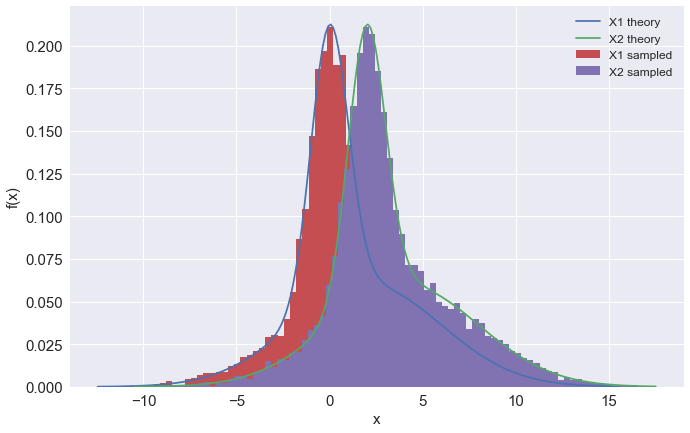

100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


In [43]:
_ = main([0.4], [2], plot=True)

Посмотрим на зависимость от $\delta$ при $\alpha=0.4$

In [44]:
delta_values = [0.01, 0.05, 0.07, 0.1, 0.12]
res1 = main([0.4], delta_values)

100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


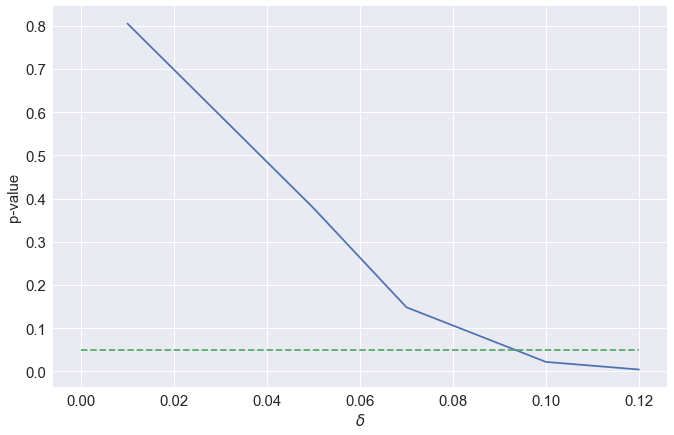

In [45]:
plt.plot([item[1] for item in res1], [item[2] for item in res1])
plt.plot([0,0.12], [0.05, 0.05], ls='--')
plt.xlabel("$\delta$")
plt.ylabel("p-value")
plt.show()

Получаем, что при сдвиге $\delta > 0.09$ значение p-value всегда меньше 0.05. Это означает, что мы не отклоняем гипотезу только при совсем малых $\delta$ (до 0.09). Т.е. критерий достаточно хорошо различает два таких распределения.

Построим глобальную зависимость, учитывающую разные $\alpha$ и $\delta$

In [48]:
alpha_values2 = np.linspace(0, 1, 30)
delta_values2 = np.linspace(0.01, 0.15, 30)
res2 = main(alpha_values2, delta_values2)


100%|██████████| 30/30 [01:32<00:00,  3.08s/it]


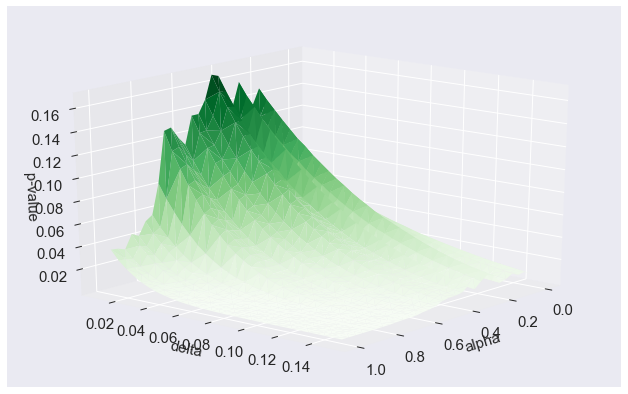

In [56]:
from mpl_toolkits import mplot3d

X = [item[0] for item in res2] #alpha
Y = [item[1] for item in res2] #delta
Z = [item[2] for item in res2] #wilcoxon

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(X, Y, Z, cmap='Greens')
ax.set_xlabel('alpha')
ax.set_ylabel('delta')
ax.set_zlabel('p-value')
ax.view_init(20, 40)

Видим, что для всех $\alpha$ тенденция, описанная выше для $\alpha=0.4$, примерно такая же. Отличие лишь в том, что при $\alpha$, близких к нулю или единице, $\text{p-value} <0.05$ даже при малых $\delta$ (соответствует случаям, когда смеси $\approx$ распределению одной из компонент смеси)

Посмотрим на зависимость мощности от $\delta$ и размера сэмплирования





  0%|          | 0/6 [00:00<?, ?it/s]



 17%|█▋        | 1/6 [00:08<00:41,  8.27s/it]



 33%|███▎      | 2/6 [00:40<01:01, 15.33s/it]



 50%|█████     | 3/6 [01:42<01:27, 29.33s/it]



 67%|██████▋   | 4/6 [06:42<03:41, 110.79s/it]



 83%|████████▎ | 5/6 [16:46<04:18, 258.59s/it]



100%|██████████| 6/6 [49:44<00:00, 497.36s/it]


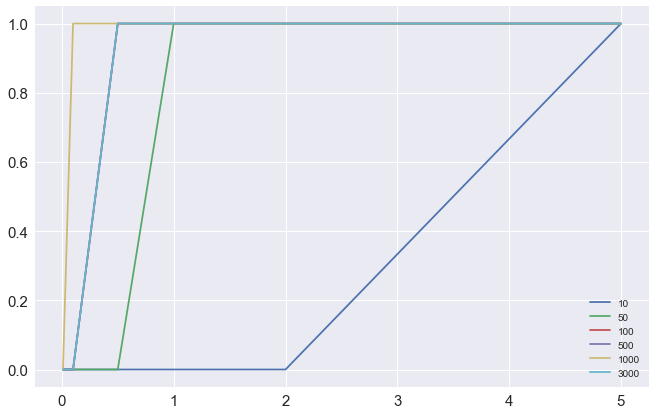

In [257]:
alpha = 0.5
deltas = [0.01, 0.1, 0.5, 1, 2, 5]
for n in tqdm([10, 50, 100, 500, 1000, 3000]):
    X=[]
    Y=[]
    for delta in deltas:
        rejected = 0
        for _ in range(1000):
            numpy.random.seed(0x5eed)
            norm_params = np.array([[0, 1],
                                    [2, 4]])
            weights = np.array([alpha, (1-alpha)])
            mixture_idx = numpy.random.choice(len(weights), size=n, replace=True, p=weights)
            y1 = numpy.fromiter((st.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                               dtype=np.float64)
            y2 = numpy.fromiter((st.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                               dtype=np.float64)+delta

            if st.wilcoxon(y2-y1)[1] <= 0.05:
                rejected += 1
        X.append(delta)
        Y.append(rejected/1000)
    
    plt.plot(X, Y, label=str(n))
plt.legend(loc='best')

По оси x – delta, y – мощность. Разные линии соттветствуют различным размерам сэмпла. Как видим, при размерах сэмплов $\geq 50$ мощность быстро переходит в единицу, т.е. ноль только при совсем малых $\delta$. Даже при малом размере сэмпла 10 при относительно небольшом $\delta$ мощность переходит в единицу

### Вывод:

Проверив консервативность и мощность критерия в зависимости от значений сдвига и весов распределений в смеси, получили, что критерий Уилкоксона отлично различает распределения, и проблемы начинаются лишь при малых сдвигах $\delta$. Можно сказать, что p-value приктически всегда ниже уровня 0.05. Зависимость мощности показала, что критерий либо всегда угадывает либо вообще не различает смеси при малых $\delta$